In [1]:
import os
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import scipy.stats as sp
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math

# Download & parse data from 2013 & 2014

In [2]:
# Read the file 'otc' & 'alpha'
url = 'https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz'
data = os.path.basename(url)
r = requests.get(url, allow_redirects=True)
open(data, 'wb').write(r.content)

url1 = 'https://snap.stanford.edu/data/soc-sign-bitcoinalpha.csv.gz'
data1 = os.path.basename(url1)
r1 = requests.get(url1, allow_redirects=True)
open(data1, 'wb').write(r1.content)

149480

In [3]:
cols = ['source', 'target', 'rating', 'time']

# parse the file: OTC
otc = pd.read_csv(data, names=cols, header=None)
otc['time'] = pd.to_datetime(otc.time * 1e9)
otc = otc.set_index(otc['time']).sort_index()
otc = otc['2013-01-01':'2014-12-31']

# Normalisation
for idx, row in otc.iterrows():
    otc.at[idx, 'rating'] = row.rating*0.1

otc.head()

# parse the file: Alpha
alpha = pd.read_csv(data1, names=cols, header=None)
alpha['time'] = pd.to_datetime(alpha.time * 1e9)
alpha = alpha.set_index(alpha['time']).sort_index()
alpha = alpha['2013-01-01':'2014-12-31']

# Normalisation
for idx, row in alpha.iterrows():
    alpha.at[idx,'rating'] = row.rating*0.1

alpha.describe()

,source,target,rating
count,8856.000000,8856.000000,8856.000000
mean,833.395325,1126.312782,0.128433
std,1610.523034,2044.464865,0.353586
min,1.000000,1.000000,-1.000000
25%,43.000000,58.000000,0.100000
50%,185.000000,229.000000,0.100000
75%,812.000000,1057.000000,0.200000
max,7604.000000,7604.000000,1.000000


In [4]:
otc.describe()

,source,target,rating
count,17207.000000,17207.000000,17207.000000
mean,3359.239960,3462.030046,0.055152
std,1428.744743,1474.125862,0.412885
min,1.000000,1.000000,-1.000000
25%,2378.000000,2565.000000,0.100000
50%,3699.000000,3750.000000,0.100000
75%,4397.500000,4579.000000,0.200000
max,5870.000000,5877.000000,1.000000


# Group by weeks

In [5]:
# OTC: Count a week of a year
otc['week'] = otc.time.dt.isocalendar().week

# new dataframe for wk1-52 in 2013
otc13 = otc['2013-01-01':'2013-12-29'] # From 2013-12-30 -> 1st wk of 2014
wks = np.unique(otc13.week) # 1-52
otc13 = otc13.set_index(otc13['week'])
otc13

# Save a group of dataframes grouped by week
df_otc13 = {}
for w in wks:
    df_otc13[w] = otc13.loc[w]

df_otc13

{1:       source  target  rating                          time  week
 week                                                            
 1        135    2877    -0.2 2013-01-01 00:49:06.559320064     1
 1       3239    2725     0.1 2013-01-01 02:13:09.566249984     1
 1       2188    2119     0.1 2013-01-01 03:44:50.117110016     1
 1       2028    2780     0.2 2013-01-01 04:00:59.719859968     1
 1       2780    2028     0.7 2013-01-01 09:18:33.907480064     1
 ...      ...     ...     ...                           ...   ...
 1       2725    2642     0.3 2013-01-06 18:27:02.266400000     1
 1       2524      23     0.1 2013-01-06 19:50:22.078560000     1
 1       3273    2898    -0.5 2013-01-06 20:23:41.032280064     1
 1       2725    1018     0.2 2013-01-06 21:47:01.950540032     1
 1       2419    2725     0.1 2013-01-06 21:53:51.373660160     1
 
 [179 rows x 5 columns],
 2:       source  target  rating                          time  week
 week                                      

In [6]:
# append nodes & edges in 2013 first
nodes_otc = []
edges_otc = []

for k in df_otc13.keys():
    # https://networkx.org/documentation/stable/reference/classes/multidigraph.html
    # https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html
    # Create a graph with the pandas dataframe
    g = nx.from_pandas_edgelist(df_otc13[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_otc.append(g.number_of_nodes())
    edges_otc.append(g.number_of_edges())

In [7]:
# Create a dataframe for wk1-52 in 2014
otc14 = otc['2013-12-30':'2014-12-28'] # From '2014-12-29': wk1 of 2015
otc14 = otc14.set_index(otc14['week'])
# otc14

# Save a group of dataframes grouped by week
df_otc14 = {}
for w in wks:
    df_otc14[w] = otc14.loc[w]
df_otc14[53] = otc['2014-12-29':'2014-12-31']

In [8]:
# append nodes & edges in 2014
for k in df_otc14.keys():
    g = nx.from_pandas_edgelist(df_otc14[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_otc.append(g.number_of_nodes())
    edges_otc.append(g.number_of_edges())

In [9]:
# ALPHA: Count a week of a year
alpha['week'] = alpha.time.dt.isocalendar().week

# new dataframe for wk1-52 in 2013
alpha13 = alpha['2013-01-01':'2013-12-29'] # From 2013-12-30 -> 1st wk of 2014
alpha13 = alpha13.set_index(alpha13['week'])

# Save a group of dataframes grouped by week
df_alpha13 = {}
for w in wks:
    df_alpha13[w] = alpha13.loc[w]

# append nodes & edges in 2013 first
nodes_alpha = []
edges_alpha = []

for k in df_alpha13.keys():
    # Create a graph with the pandas dataframe
    g = nx.from_pandas_edgelist(df_alpha13[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_alpha.append(g.number_of_nodes())
    edges_alpha.append(g.number_of_edges())

# Create a dataframe for wk1-52 in 2014
alpha14 = alpha['2013-12-30':'2014-12-28'] # From '2014-12-29': wk1 of 2015
alpha14 = alpha14.set_index(alpha14['week'])

# Save a group of dataframes grouped by week
df_alpha14 = {}
for w in wks:
    df_alpha14[w] = alpha14.loc[w]
df_alpha14[53] = alpha['2014-12-29':'2014-12-31']


# append nodes & edges in 2014
for k in df_alpha14.keys():
    g = nx.from_pandas_edgelist(df_alpha14[k], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    nodes_alpha.append(g.number_of_nodes())
    edges_alpha.append(g.number_of_edges())

In [10]:
lst = []
for i in range(1,53):
    lst.append(i)

for i in range(1,54):
    lst.append(i)

print(len(lst))
print(lst[::20])
# otc14.loc[49]

105
[1, 21, 41, 9, 29, 49]


# Basic statistics

In [11]:
g1 = nx.from_pandas_edgelist(otc, 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
print(f'OTC - Total number of nodes: {g1.number_of_nodes()}, Total number of edges: {g1.number_of_edges()}')

g2 = nx.from_pandas_edgelist(alpha, 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
print(f'ALPHA - Total number of nodes: {g2.number_of_nodes()}, Total number of edges: {g2.number_of_edges()}')

OTC - Total number of nodes: 3317, Total number of edges: 17207
ALPHA - Total number of nodes: 1691, Total number of edges: 8856


In [12]:
print(f'OTC: max node {max(nodes_otc)} / min node {min(nodes_otc)}')
print(f'OTC: max link {max(edges_otc)} / min link {min(edges_otc)}')
print(f'ALPHA: max node {max(nodes_alpha)} / min node {min(nodes_alpha)}')
print(f'ALPHA: max link {max(edges_alpha)} / min link {min(edges_alpha)}')

OTC: max node 372 / min node 25
OTC: max link 781 / min link 26
ALPHA: max node 191 / min node 21
ALPHA: max link 282 / min link 20


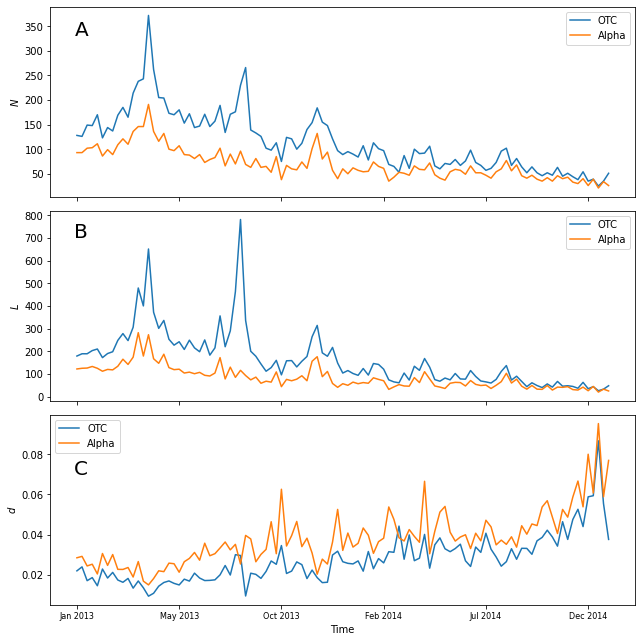

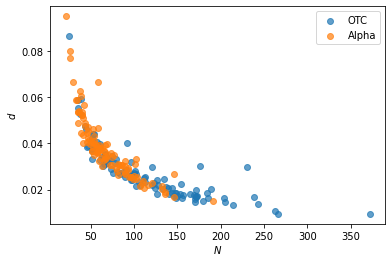

In [13]:
# Reference: The evolving liaisons between the transaction networks of Bitcoin and its price dynamics
label = ['Jan 2013', 'May 2013', 'Oct 2013', 'Feb 2014', 'Jul 2014', 'Dec 2014']

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(9,9))

ax1.plot(nodes_otc, label='OTC')
ax1.plot(nodes_alpha, label='Alpha')
ax1.set_ylabel("N", style='italic')
ax1.legend()
ax1.text(x=-0.5, y=330, s='A', fontsize=20)
ax1.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off
# ax1.set_title('Evolution of the number of nodes')


ax2.plot(edges_otc, label='OTC')
ax2.plot(edges_alpha, label='Alpha')
ax2.set_ylabel("L", style='italic')
ax2.legend()
ax2.text(x=-0.5, y=700, s='B', fontsize=20)
ax2.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off


density_o = []
density_a = []
for i in range(len(nodes_otc)):
    # OTC
    rho1 = 2*edges_otc[i] / (nodes_otc[i]*(nodes_otc[i]-1))
    density_o.append(rho1)
    # Alpha
    rho2 = 2*edges_alpha[i] / (nodes_alpha[i]*(nodes_alpha[i]-1))
    density_a.append(rho2)
ax3.plot(density_o, label='OTC')
ax3.plot(density_a, label='Alpha')
ax3.set_xlabel("Time")
ax3.legend()
ax3.text(x=-0.5, y=0.07, s='C', fontsize=20)
ax3.set_ylabel("d", style='italic')
ax3.set_xticks(np.arange(0,106,20), label, fontsize=8)


fig.tight_layout(pad=1.0)
plt.show()


# N vs d
plt.scatter(nodes_otc, density_o, label='OTC', alpha=0.7)
plt.scatter(nodes_alpha, density_a, label='Alpha', alpha=0.7)
plt.ylabel('d', style='italic')
plt.xlabel('N', style='italic')
plt.legend()

plt.show()

# Degree Centrality

Function to find max/min centrality nodes

In [14]:
def return_nodes(dic):
    max_cen = -math.inf
    max_node = 0

    min_cen = math.inf
    min_node = 0
    
    for k,v in dic.items():
        if v >= max_cen:
            max_cen = v
            max_node = k

        if v <= min_cen:
            min_cen = v
            min_node = k
    
    return max_node, min_node

In [15]:
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_directed.html#sphx-glr-auto-examples-drawing-plot-directed-py
# https://stackoverflow.com/questions/22967086/colouring-edges-by-weight-in-networkx
# https://www.tutorialspoint.com/colouring-the-edges-by-weight-in-networkx-matplotlib
def plot_centrality(graph, title):
    fig = plt.figure(figsize=(8, 6))

    degree_cen = nx.degree_centrality(graph)
    pos = nx.spring_layout(graph)

    cen = np.fromiter(degree_cen.values(), float)
    node_sizes = cen / np.max(cen) * 200
    normalize = mcolors.Normalize(vmin=cen.min(), vmax=cen.max())
    colormap = cm.RdYlGn # https://matplotlib.org/stable/tutorials/colors/colormaps.html    

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(cen)

    edges, wt = zip(*nx.get_edge_attributes(graph, 'rating').items())
    for value in wt:
        value = (value+1)/2
        
    plt.colorbar(scalarmappaple)
    nc = nx.draw_networkx_nodes(
        graph, pos, nodelist=graph.nodes(), node_size=node_sizes,
        node_color=node_sizes, cmap=colormap, alpha=0.8) # linewidths=2.0,
    ec = nx.draw_networkx_edges(
        graph, pos, arrows=True, width=2,
        edge_color=wt, alpha=0.2)
    plt.title(f'Degree centrality in {title}')
    ax = plt.axis('off')

    plt.show()

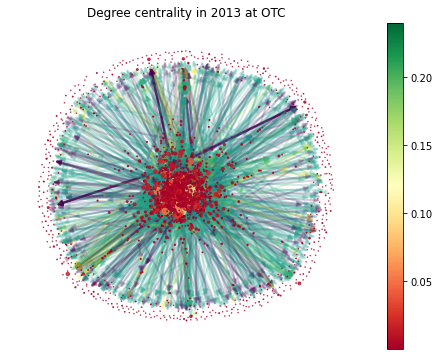

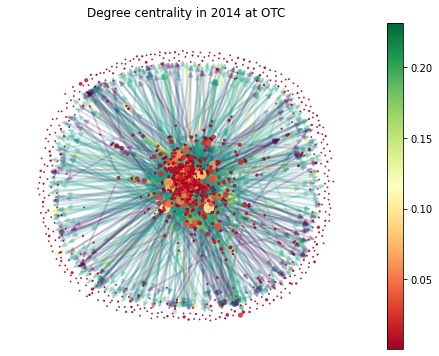

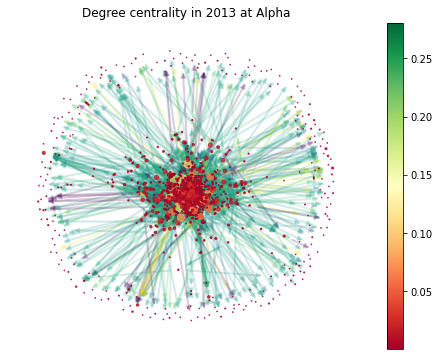

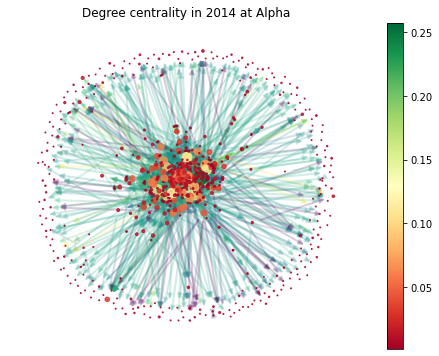

In [44]:
deg_max = []
deg_min = []
deg_in_max = []
deg_in_min = []
deg_out_max = []
deg_out_min = []
btn_max = []
btn_min = []
clo_max = []
clo_min = []
eig_max = []
eig_min = []

df_lst = [otc['2013-01-01':'2013-12-31'], otc['2014-01-01':'2014-12-31'], alpha['2013-01-01':'2013-12-31'], alpha['2014-01-01':'2014-12-31']]
title = ['2013', '2014']
platform = ['OTC', 'Alpha']

for i in range(4):
    g = nx.from_pandas_edgelist(df_lst[i], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
    # https://www.sciencedirect.com/topics/computer-science/degree-centrality
    # Centralities
    degree_cen = nx.degree_centrality(g)
    max_node, min_node = return_nodes(degree_cen)
    deg_max.append((max_node, degree_cen[max_node]))
    deg_min.append((min_node, degree_cen[min_node]))

    deg_cen_in = nx.in_degree_centrality(g)
    max_node_di, min_node_di = return_nodes(deg_cen_in)
    deg_in_max.append((max_node_di, deg_cen_in[max_node_di]))
    deg_in_min.append((min_node_di, deg_cen_in[min_node_di]))

    deg_cen_out = nx.out_degree_centrality(g)
    max_node_do, min_node_do = return_nodes(deg_cen_out)
    deg_out_max.append((max_node_do, deg_cen_out[max_node_do]))
    deg_out_min.append((min_node_do, deg_cen_out[min_node_do]))

    between_cen = nx.betweenness_centrality(g)
    max_node_b, min_node_b = return_nodes(between_cen)
    btn_max.append((max_node_b, between_cen[max_node_b]))
    btn_min.append((min_node_b, between_cen[min_node_b]))

    close_cen = nx.closeness_centrality(g)
    max_node_c, min_node_c = return_nodes(close_cen)
    clo_max.append((max_node_c, close_cen[max_node_c]))
    clo_min.append((min_node_c, close_cen[min_node_c]))
    
    # eigenvector centrality: 'power iteration failed to converge within 100 iterations')
    # NetworkXNotImplemented: not implemented for multigraph type
    g_e = nx.DiGraph(g)
    eigen_cen = nx.eigenvector_centrality(g_e)
    max_node_e, min_node_e = return_nodes(eigen_cen)
    eig_max.append((max_node_e, eigen_cen[max_node_e]))
    eig_min.append((min_node_e, eigen_cen[min_node_e]))

    if i < 2:
        plot_centrality(g, title[i%2] + ' at ' + platform[0])
    else:
        plot_centrality(g, title[i%2] + ' at ' + platform[1])

In [ ]:
g = nx.from_pandas_edgelist(df_lst[0], 'source', 'target', edge_attr=['rating'], create_using=nx.MultiDiGraph())
nx.degree_centrality(g)

In [46]:
# Will put them in a table at the report / presentation file
print(deg_max)
print(deg_min)
print(deg_in_max)
print(deg_in_min)
print(deg_out_max)
print(deg_out_min)
print(btn_max)
print(btn_min)
print(clo_max)
print(clo_min)
print(eig_max)
print(eig_min)

[(2642, 0.2402088772845953), (3988, 0.23164335664335664), (3, 0.28074074074074074), (58, 0.257703081232493)]
[(5221, 0.0003729951510630362), (5877, 0.0008741258741258741), (3339, 0.0007407407407407407), (3417, 0.0014005602240896359)]
[(2642, 0.1215964192465498), (3988, 0.08216783216783216), (3, 0.14296296296296296), (58, 0.09103641456582633)]
[(1376, 0.0), (3829, 0.0), (7476, 0.0), (2400, 0.0)]
[(2642, 0.11861245803804552), (3988, 0.14947552447552448), (3, 0.13777777777777778), (58, 0.16666666666666666)]
[(5221, 0.0), (5877, 0.0), (3339, 0.0), (3417, 0.0)]
[(2642, 0.13188420825107242), (3988, 0.12672201377540115), (3, 0.1474906521215958), (58, 0.11754976801398126)]
[(5258, 0.0), (5877, 0.0), (3339, 0.0), (3417, 0.0)]
[(2642, 0.32919429124546706), (4291, 0.23615110379816262), (3, 0.35196597325186085), (19, 0.24660833971198667)]
[(1376, 0.0), (3829, 0.0), (7476, 0.0), (2400, 0.0)]
[(2642, 0.36189240082237256), (4291, 0.24830879263578118), (3, 0.35897222830944686), (19, 0.2468203364631363

In [64]:
# OTC
max_in = []
min_in = []
low_deg = []

for i, row in df_lst[0].iterrows():
    if row.target == 2642:
        max_in.append(row.rating)
    if row.target == 1376:
        min_in.append(row.rating)
    if row.target == 5221:
        low_deg.append(row.rating)
        print(row.source)
print('others rated 2642 in 2013', np.mean(max_in))
print('# of others rated 1376 in 2013', len(min_in))
print('# of others rated 5221 in 2013', len(low_deg))

max_in = []
max_in1 = []
min_in = []

for i, row in df_lst[1].iterrows():
    if row.target == 3988:
        max_in.append(row.rating)
    if row.target == 4291:
        max_in1.append(row.rating)
    if row.target == 3829:
        min_in.append(row.rating)

print('others rated 3988 in 2014', np.mean(max_in))
print('others rated 4291 in 2014', np.mean(max_in1))
print('# of others rated 3829 in 2014', len(min_in))

4315
others rated 2642 in 2013 0.26871165644171785
# of others rated 1376 in 2013 0
# of others rated 5221 in 2013 1
others rated 3988 in 2014 0.1404255319148936
others rated 4291 in 2014 0.2666666666666668
# of others rated 3829 in 2014 0


In [62]:
# ALPHA
max_in = []
min_in = []
low_deg = []

for i, row in df_lst[2].iterrows():
    if row.target == 3:
        max_in.append(row.rating)
    if row.target == 3339:
        min_in.append(row.rating)
        print(row.source)
    if row.target == 7476:
        low_deg.append(row.rating)
print('others rated 3 in 2013', np.mean(max_in))
print('# of others rated 3339 in 2013', len(min_in))
print('# of others rated 7476 in 2013', len(low_deg))

max_in = []
min_in = []
low_deg = []

for i, row in df_lst[3].iterrows():
    if row.target == 58:
        max_in.append(row.rating)
    if row.target == 3417:
        low_deg.append(row.rating)
        print(row.source)
    if row.target == 2400:
        min_in.append(row.rating)

print('others rated 58 in 2014', np.mean(max_in))
print('# of others rated 3417 in 2014', len(low_deg))
print('# of others rated 2400 in 2014', len(min_in))

1
others rated 3 in 2013 0.12953367875647673
# of others rated 3339 in 2013 1
# of others rated 7476 in 2013 0
53
others rated 58 in 2014 0.14615384615384616
# of others rated 3417 in 2014 1
# of others rated 2400 in 2014 0
